# Optimizing the Vectorized Simulations #

Besides speed, the benefit of using the vectorized simulation based on the torch framework
is that we can track all operations that happen across a simulation. This allows us to find
the gradients with respect to any intermediate variable, and more importantly the gradient
of the yield the final copies of some complex with respect to initial parameters.

## An Introduction to Automatic Differentiation ##

Automatic differentiation is a powerful technique based on a simple principle of calculus,
the multivariable chain rule. Imagine we have function $ y = f(x, w)$ and we want to minimize $y$ by adjusting parameter $w$ we can
this by computing $\frac {\partial y} {\partial w}$. Automatic differentiation allows us to do this
for arbitrary function $f$ without needing to know $f$ in advance.

Whenever variable $u$ is involved in any operation, we create a new internal variable $v$ representing the result of
the operation, pointer back to $w$ and any other variables, and the function describing the partial $\frac {\partial v} {\partial u}$.
In this way we construct a directed acyclic "compuation graph", where $w$ and other input variable $x$ are leaves and the final optimization
target $y$ is the root.

We can now calculate the partial of $y$ with respect to each intermediate variable, and eventually $w$ by repeatedly
applying the chain rule of differentiation, $\frac {\partial y} {\partial u} = \frac {\partial y} {\partial v}  \frac {\partial v} {\partial u}$

## Applying to Our Use Case##

We can easily write the simulator described in the `vectorized_network_simulation.ipynb` notebook as a function. Let's Define:

- Simulator: $S$
- Vector of association constants: $\vec{k_{on}}$
- Vector of Reaction $\Delta G$s: $\vec{G}$
- Vector of initial copy numbers: $\vec{C_o}$
- Matrix mapping species to reactions: $\textbf{M}$
- Simulation run time: $t$
- Final copies of complete complex: $Y$
- maximum possible yield: $min(\vec{C_o})$

The simulator itself can be expressed as:

$Y = S(\vec{k_{on}}, \vec{G}, \vec{C_o}, \textbf{M}, t)$

From the yield $Y$ we can construct the full loss term:

$L = \frac{-Y}{min(\vec{C_o})} + ReLU(-1*(k - min\_constant))$

Here the first term is the percent of the theoretical maximum possible complete complex yield,
and the second term is designed to prevent the on or off association constants from getting unreasonably small
or negative. The ReLU function is a piecewise function that will be a linear positive penalty when $k < min\_constant$,
and will equal $0$ otherwise. Minimizing the full objective $L$ w.r.t. $k_{on}$ will find values for $k_{on}$ that
maximize full complex yield while still being physically reasonable.

Automatic differentiation as described in the above section provide a method for doing this. We can run the simulation
until completion, all the while constructing the computation graph. We can then compute all the gradients, and then
step the parameter values in the direction of the gradient.

In other words, we compute $\frac{\partial L}{\partial \vec{k_{on}}}$ via automatic differentiation,
and then do $k_{on} = k_{on} + \lambda * \frac{\partial L}{\partial \vec{k_{on}}}$.

We preform a simulation then update the parameters in the direction of the gradient a set number of times
before stopping.

## Optimization Example With AP2 ##

In [1]:
# first we need to import the required modules
# make sure jupyter path is correct for loading local modules
import sys
sys.path.append("../../")
import pickle as pk
import numpy as np

import copy
from steric_free_simulator import Optimizer
from steric_free_simulator import ReactionNetwork

/home/spencerloggia/Projects/biphy/multi_assembly/steric_free_simulator/energy_space_explorer.py:8: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.relax import *


To begin, we need to generate the reaction network from the input files (see `reaction_network_building.ipynb`).
We can't directly resolve a vectorized network from an input file.

In [3]:
base_input = './input_files/ap2.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

We can feed the vanilla (networkx based) network into the optimizer and vectorized simulator, but it will be copied and
converted to a vectorized network. Let's ensure the network is set to the proper initial conditions and then initialize the
optimizer.

**Optimization and Simulation Parameters**:

- **sim_runtime**: time (in seconds) that the simulation will run for.
- **optim_iterations**: number of simulations to run, optimizing parameters at each one.
- **learning rate**: factor to multiply calculated gradients by.
- **device**: The hardware device to run simulations and optimizations on.

If the parameter is not specified at optimizer construction, it is given a default value.

In [4]:
rn.reset()
optim = Optimizer(reaction_network=rn,
                  sim_runtime=1,
                  optim_iterations=500,
                  learning_rate=.001,
                  device='cpu')

Using CPU


Now we can run the optimization. After optimization, we write the new "optimized" parameters
into a copy of a reaction network so that we can inspect them if desired.

In [5]:
optim.optimize()
final_rn = copy.deepcopy(rn)
optim.rn.update_reaction_net(final_rn)

Using CPU
yield on sim iteration 0 was 28.9%
current params: tensor([1.0010, 0.9990, 0.9990, 1.0010, 0.9990, 1.0010, 1.0010, 1.0010, 0.9990,
        0.9990, 1.0010, 1.0010, 0.9990, 0.9990, 1.0010, 0.9990, 1.0010, 1.0010,
        0.9990, 0.9990, 1.0010, 0.9990], dtype=torch.float64)
Using CPU
yield on sim iteration 1 was 28.9%
current params: tensor([1.0020, 0.9980, 0.9980, 1.0020, 0.9980, 1.0020, 1.0020, 1.0020, 0.9980,
        0.9980, 1.0020, 1.0020, 0.9980, 0.9980, 1.0020, 0.9980, 1.0020, 1.0020,
        0.9980, 0.9980, 1.0020, 0.9980], dtype=torch.float64)
Using CPU
yield on sim iteration 2 was 28.9%
current params: tensor([1.0030, 0.9970, 0.9970, 1.0030, 0.9970, 1.0030, 1.0030, 1.0030, 0.9970,
        0.9970, 1.0030, 1.0030, 0.9970, 0.9970, 1.0030, 0.9970, 1.0030, 1.0030,
        0.9970, 0.9970, 1.0030, 0.9970], dtype=torch.float64)
Using CPU
yield on sim iteration 3 was 28.9%
current params: tensor([1.0040, 0.9960, 0.9960, 1.0040, 0.9960, 1.0040, 1.0040, 1.0040, 0.9960,
        0.

Let's visulalize the reults. The Optimizer tracks observables across all simulation iterations,
and thus we can use its `plot_observables` function to plot the results of a single simulation

**Plot the first simulation, before any optimization:**

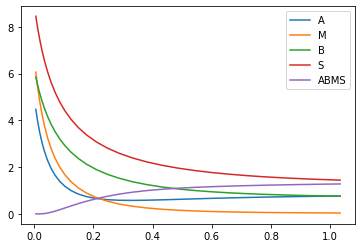

In [6]:
optim.plot_observable(iteration=0)

**Plot the final simulation, after all optimization iterations:**


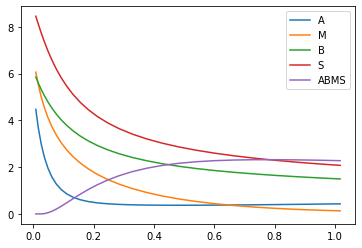

In [7]:
optim.plot_observable(iteration=-1)


Plot the change in complex yield over time

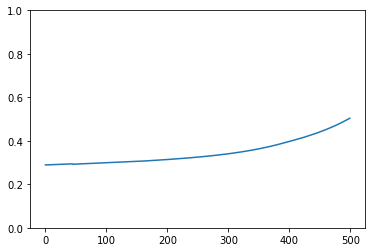

In [8]:
optim.plot_yield()


Clearly the optimizer was able to increase the total yield of the final complex at time 1 second.
The explanation for this will be left to the results notebook.
